# Einstein-Bianchi equations

using 
* hyperbolic evolution for the divergence constraint
* iterative solvers for all three mass matrices


$$
\frac{d}{dt} \left( \begin{array}{c} E \\ v \\ H \end{array} \right) = 
\left( \begin{array}{ccc} 
 & & C^T \\
 & & D \\
 -C & -D^T & 
\end{array} \right)
\left( \begin{array}{c} E \\ v \\ H \end{array} \right) 
$$

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
mesh = Mesh(unit_cube.GenerateMesh(maxh=0.1))

In [2]:
n = specialcf.normal(3)

def CurlTHcc2Hcd(E,dH):
    return InnerProduct(curl(E).trans, dH)*dx \
       +InnerProduct(Cross(E*n, n), dH*n)*dx(element_boundary= True)

def DivHcdHd(H,dv):
    return div(H)*dv*dx - H*n*n * dv*n * dx(element_boundary= True)

In [3]:
order = 2

fescc = HCurlCurl(mesh, order=order)
fescd = HCurlDiv(mesh, order=order)
fesd = HDiv(mesh, order=order, RT=True)

E, dE = fescc.TnT()
v, dv = fesd.TnT()
H, dH = fescd.TnT()

In [4]:
bfcurlT = BilinearForm(CurlTHcc2Hcd(E, fescd.TestFunction())).Assemble()
bfdiv = BilinearForm(DivHcdHd(H, dv)).Assemble()

In [15]:
if False:   # condense
    massE = BilinearForm(InnerProduct(E,dE)*dx, condense=True).Assemble()
    matE = massE.mat
    preE = matE.CreateBlockSmoother(fescc.CreateSmoothingBlocks(blocktype="edgepatch", eliminate_internal=True), GS=False)

    massEinvSchur = CGSolver (matE, preE)
    ext = IdentityMatrix()+massE.harmonic_extension
    extT = IdentityMatrix()+massE.harmonic_extension_trans
    massEinv =  ext @ massEinvSchur @ extT + massE.inner_solve
else:
    massE = BilinearForm(InnerProduct(E,dE)*dx).Assemble()
    matE = massE.mat
    preE = matE.CreateBlockSmoother()#fescc.CreateSmoothingBlocks(blocktype="edgepatch"), GS=False)
    massEinv = CGSolver (matE, preE)
    
from ngsolve.la import EigenValues_Preconditioner
print (EigenValues_Preconditioner(matE, preE).NumPy())

TypeError: object of type 'ngsolve.la.SparseMatrixdouble' has no len()

In [6]:
if False:   # condense
    massH = BilinearForm(InnerProduct(H,dH)*dx, condense=True).Assemble()
    matH = massH.mat
    preH = matH.CreateBlockSmoother(fescd.CreateSmoothingBlocks(blocktype="facepatch", eliminate_internal=True), GS=False)

    massHinvSchur = CGSolver (matH, preH)
    ext = IdentityMatrix()+massH.harmonic_extension
    extT = IdentityMatrix()+massH.harmonic_extension_trans
    massHinv =  ext @ massHinvSchur @ extT + massH.inner_solve
else:
    massH = BilinearForm(InnerProduct(H,dH)*dx).Assemble()
    matH = massH.mat
    preH = matH.CreateBlockSmoother(fescd.CreateSmoothingBlocks(blocktype="facepatch"), GS=True)
    massHinv = CGSolver (matH, preH)
    
from ngsolve.la import EigenValues_Preconditioner
print (EigenValues_Preconditioner(matH, preH).NumPy())

AttributeError: 'ngsolve.comp.HCurlDiv' object has no attribute 'CreateSmoothingBlocks'

In [7]:
massv = BilinearForm(InnerProduct(v,dv)*dx, condense=True).Assemble()
matv = massv.mat
prev = matv.CreateSmoother(fesd.FreeDofs(True), GS=False)

massvinvSchur = CGSolver (matv, prev)
ext = IdentityMatrix()+massv.harmonic_extension
extT = IdentityMatrix()+massv.harmonic_extension_trans
massvinv =  ext @ massvinvSchur @ extT + massv.inner_solve

from ngsolve.la import EigenValues_Preconditioner
print (EigenValues_Preconditioner(matv, prev).NumPy())

[0.3257949  0.35666375 0.4001852  0.4546468  0.52096542 0.59632293
 0.68327291 0.78066327 0.89053594 0.99887391 1.11918535 1.24094956
 1.37073042 1.4994995  1.62861531 1.75784143 1.88864073 2.00437623
 2.12983877 2.23229853 2.3351803  2.4268745  2.46962603 2.54886727
 2.60785301]


exact inverses for testing:

In [8]:
# massE = BilinearForm(InnerProduct(E,dE)*dx).Assemble()
# massEinv = massE.mat.Inverse(inverse="sparsecholesky")

# massH = BilinearForm(InnerProduct(H,dH)*dx).Assemble()
# massHinv = massH.mat.Inverse(inverse="sparsecholesky")

# massv = BilinearForm(InnerProduct(v,dv)*dx).Assemble()
# massvinv = massv.mat.Inverse(inverse="sparsecholesky")

In [9]:
gfE = GridFunction(fescc)
gfH = GridFunction(fescd)
gfv = GridFunction(fesd)

In [10]:
# initial conditions ....
gfH.vec[:] = 0.0
gfE.vec[:] = 0.0
gfv.vec[:] = 0.0

peak = exp(-((x-0.5)**2+(y-0.5)**2+(z-0.5)**2)/ 0.2**2 )
gfE.Set ( ((peak, 0,0), (0,0,0), (0,0,-peak) ))

In [11]:
t = 0
tend = 10
dt = 5e-3
# tend = 5 * dt
scene = Draw(Norm(gfH), mesh)

energytrace = []
with TaskManager():  #  pajetrace=10**8):
    while t < tend:
        gfE.vec.data += -dt * massEinv@bfcurlT.mat.T * gfH.vec
        gfv.vec.data += -dt * massvinv@bfdiv.mat * gfH.vec

        hv = bfcurlT.mat * gfE.vec + bfdiv.mat.T * gfv.vec
        gfH.vec.data += dt * massHinv * hv
        scene.Redraw()
    
        energytrace.append (Integrate ( Norm (Trace(gfE)), mesh ))
        t += dt


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

NameError: name 'massEinv' is not defined

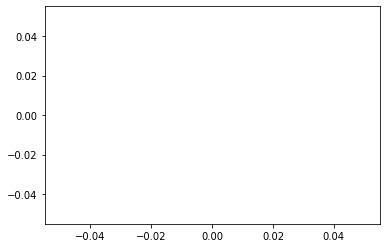

In [12]:
import matplotlib.pyplot as plt
plt.plot (energytrace)